Code to generate and analyze the Liouville spectrum of the 3 level atom case

In [ ]:
import qutip as qt
import numpy as np
import time
import matplotlib.pyplot as plt

In [106]:
plt.rcParams.update({
    # LaTeX rendering and font configuration
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],  # mathpazo corresponds to Palatino font
    "font.size": 18,  # Base font size
    
    # Font sizes for specific elements
    "axes.titlesize": 22,        # Axis title
    "axes.labelsize": 20,         # Axis labels
    "xtick.labelsize": 18,        # X-ticks
    "ytick.labelsize": 18,        # Y-ticks
    "legend.fontsize": 18,        # Legend
    "figure.titlesize": 24,       # Figure title
    
    # LaTeX preamble packages
    "text.latex.preamble": r"""
        \usepackage{amsmath}
        \usepackage{amsfonts}
        \usepackage{amssymb}
        \usepackage{lmodern}
        \usepackage{mathpazo}
    """
})

In [39]:
# Parameters
g, κ = 0.1, 1.0
Δ1, Δ2 = 2*np.pi * 1.0*g, -2*np.pi *1.0*g
ϕ = 0
η = 0.5*g 

N = 4  # Number of atoms (adjust as needed)


Omega = 2*η*g/κ    # Rabi drive strength
varphi = np.pi/2   # Phase 
gamma = 4*g*g/(N*κ)     # Dissipation rate
Delta_1 = Δ1    # Detuning of state 1 from 0
Delta_2 = Δ2   # Detuning of state 2 from 0



# Single-atom operators
sigma_01 = qt.projection(3, 0, 1)  # |0⟩⟨1|
sigma_02 = qt.projection(3, 0, 2)  # |0⟩⟨2|
sigma_10 = sigma_01.dag()
sigma_20 = sigma_02.dag()
proj_1 = qt.projection(3, 1, 1)    # |1⟩⟨1|
proj_2 = qt.projection(3, 2, 2)    # |2⟩⟨2|
id3 = qt.qeye(3)                   # Identity for a single atom

# Initialize composite operators for N atoms
H_detuning = 0
H_drive = 0
c_ops = []

for i in range(N):
    # Detuning terms for atom i
    H_detuning_i = (
        Delta_1 * qt.tensor([id3]*i + [proj_1] + [id3]*(N-i-1)) +
        Delta_2 * qt.tensor([id3]*i + [proj_2] + [id3]*(N-i-1)))
    H_detuning += H_detuning_i

    # Drive terms for atom i
    drive_i = Omega * (
        qt.tensor([id3]*i + [sigma_01] + [id3]*(N-i-1)) +
        qt.tensor([id3]*i + [sigma_10] + [id3]*(N-i-1)) +
        np.exp(-1j * varphi) * qt.tensor([id3]*i + [sigma_02] + [id3]*(N-i-1)) +
        np.exp(-1j * varphi) * qt.tensor([id3]*i + [sigma_20] + [id3]*(N-i-1)))
    H_drive += drive_i

    # Dissipator for atom i
    L_i = np.sqrt(gamma) * (
        qt.tensor([id3]*i + [sigma_01] + [id3]*(N-i-1)) +
        np.exp(-1j * varphi) * qt.tensor([id3]*i + [sigma_02] + [id3]*(N-i-1)))
    c_ops.append(L_i)

# Full Hamiltonian and Liouvillian
H = H_detuning + H_drive
liouv = qt.liouvillian(H, c_ops)

In [ ]:
eigenvalues = liouv.eigenenergies(sparse=True, sort='high',eigvals=15, tol=1e-6)
sorted_indices = np.argsort(-np.real(eigenvalues))
eigenvalues = eigenvalues[sorted_indices]

# Plot eigenvalues
real_parts = np.real(eigenvalues)
imag_parts = np.imag(eigenvalues)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(real_parts, imag_parts, color='black', label='Eigenvalues', s=50)

plt.xlabel(r'Re($\lambda$)')
plt.ylabel(r'Im($\lambda$)')
plt.xticks([0,-1e-5],[0, 1])
plt.xlim(-1.2e-5,5e-8)


plt.show()

In [45]:
eigenvalues = liouv.eigenenergies(sparse=True, sort='high',eigvals=16, tol=1e-3)
sorted_indices = np.argsort(-np.real(eigenvalues))
eigenvalues = eigenvalues[sorted_indices]

# Plot eigenvalues
real_parts = np.real(eigenvalues)
imag_parts = np.imag(eigenvalues)
#np.savetxt('Liouv+Det_real.txt', real_parts)
#np.savetxt('Liouv+Det_imag.txt', imag_parts)

np.savetxt('Liouv-Det_real.txt', real_parts)
np.savetxt('Liouv-Det_imag.txt', imag_parts)



Plotting both eDFS and DFS on single plot

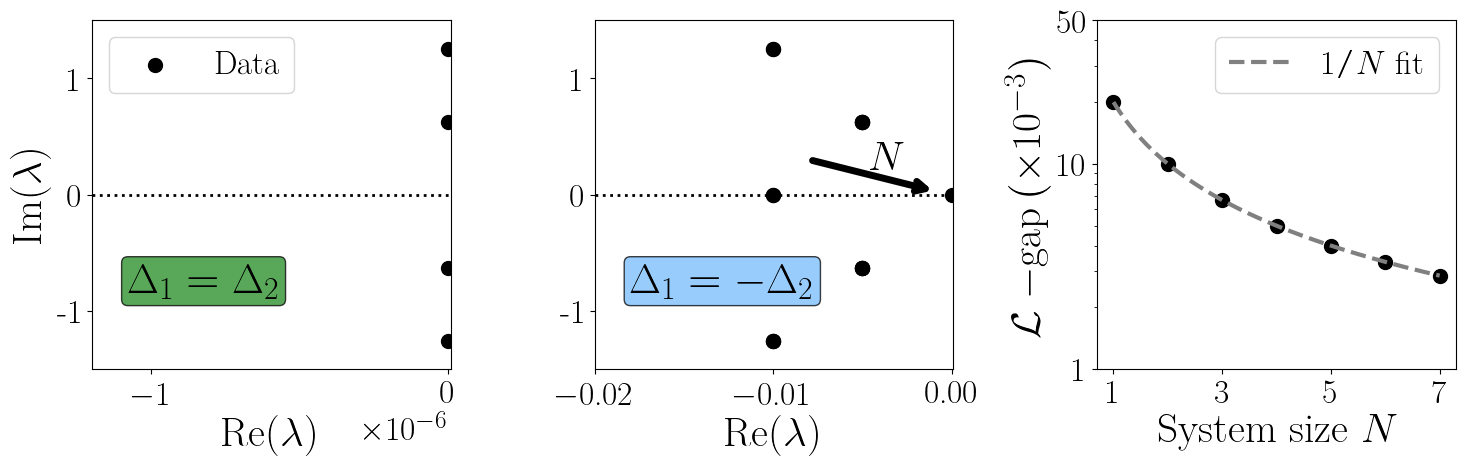

In [160]:
# — your data placeholders — 
# (we need  real_parts1, imag_parts1, real_parts2, imag_parts2, Ns, gaps, x_fit, fit defined)

real1 = np.loadtxt('Liouv+Det_real.txt')
imag1 = np.loadtxt('Liouv+Det_imag.txt')
parts1 = (real1, imag1)

real2 = np.loadtxt('Liouv-Det_real.txt')
imag2 = np.loadtxt('Liouv-Det_imag.txt')
parts2 = (real2, imag2)

gaps = np.loadtxt('gaps.txt') 


fig = plt.figure(figsize=(15, 5))

# Left panel
ax0 = fig.add_subplot(1, 3, 1)
ax0.scatter(parts1[0], parts1[1], color='black', label='Data', s=100)
ax0.set_xlabel(r'Re($\lambda$)')
ax0.set_ylabel(r'Im($\lambda$)')
ax0.set_xticks([0, -1e-6])
ax0.set_yticks([-1,0,1],[-1,0,1])
ax0.set_xlim(-1.2e-6, 1e-8)
ax0.set_ylim(-1.5,1.5)
ax0.axhline(0, color="black", lw=2, linestyle=":")
ax0.text(
    0.1, 0.2, r"$\mathrm{\Delta_1}=\mathrm{\Delta_2}$",
    transform=ax0.transAxes,
    fontsize=30,
    color="black",
    va="bottom",
    ha="left",
    bbox=dict(facecolor="forestgreen", edgecolor="black", boxstyle="round,pad=0.15", alpha=0.75)
)

ax0.legend(loc="upper left")

# Middle panel (shares y-axis with left)
ax1 = fig.add_subplot(1, 3, 2, sharey=ax0)
ax1.scatter(parts2[0], parts2[1], color='black', label='Data', s=100)
ax1.set_xlabel(r'Re($\lambda$)')
# no need to set ylabel again since shared
ax1.axhline(0, color="black", lw=2, linestyle=":")
ax1.set_xticks([0,  -1e-2, -2e-2])
ax1.set_yticks([-1,0,1],[-1,0,1])
ax1.set_xlim(-2e-2, 1e-4)
ax1.set_ylim(-1.5,1.5)
ax1.text(
    0.1, 0.2, r"$\mathrm{\Delta_1}=-\mathrm{\Delta_2}$",
    transform=ax1.transAxes,
    fontsize=30,
    color="black",
    va="bottom",
    ha="left",
    bbox=dict(facecolor="xkcd:sky blue", edgecolor="black", boxstyle="round,pad=0.15", alpha=0.75)
)
ax1.annotate(
    '', 
    xy=(0.95, 0.51),       # arrow head (in axes fraction)
    xytext=(0.6, 0.6),   # arrow tail
    xycoords='axes fraction',
    arrowprops=dict(arrowstyle='->', lw=5)
)
ax1.text(
    0.81, 0.55, r'$N$',
    transform=ax1.transAxes,
    va='bottom', ha='center',
    fontsize=30
)

# Right panel: finite‐size scaling
ax2 = fig.add_subplot(1, 3, 3)
ax2.plot(x_fit, fit*1e3, linestyle='--', color='grey', label=r'$1/N$ fit', lw=3)
ax2.scatter(Ns, gaps*1e3, color='black', s=100)
ax2.set_xlabel(r'System size $N$')
ax2.set_ylabel(r'$\mathcal{L}\;\mathrm{-gap\,} (\times10^{-3})$')
ax2.legend()
ax2.set_yscale('log')
ax2.set_yticks([50, 10, 1], [50, 10,1])
ax2.set_xticks([1,3,5,7])
# labels already match ticks
ax2.tick_params(axis='both', which='major')

fig.tight_layout()
plt.show()

plt.savefig("fig4.svg", bbox_inches="tight")

Scaling of Liouvillian gap

In [ ]:
def dominant_gap_real(N):
    """
    Build the N-atom Liouvillian, compute its low-lying spectrum,
    and return the real part of the first nonzero eigenvalue (the gap).
    """
    gamma = 4*g*g/(N*κ)     # Dissipation rate

    # Single-atom operators
    id3     = qt.qeye(3)
    s01, s02 = qt.projection(3,0,1), qt.projection(3,0,2)
    s10, s20 = s01.dag(), s02.dag()
    p1, p2   = qt.projection(3,1,1), qt.projection(3,2,2)

    H_det = 0
    H_drv = 0
    c_ops = []

    for i in range(N):
        # Detuning
        H_det += (Δ1 * qt.tensor([id3]*i + [p1]   + [id3]*(N-i-1))
                + Δ2 * qt.tensor([id3]*i + [p2]   + [id3]*(N-i-1)))
        # Coherent drive
        H_drv += Omega * (
            qt.tensor([id3]*i + [s01] + [id3]*(N-i-1))
          + qt.tensor([id3]*i + [s10] + [id3]*(N-i-1))
          + np.exp(-1j*varphi)*qt.tensor([id3]*i + [s02] + [id3]*(N-i-1))
          + np.exp(-1j*varphi)*qt.tensor([id3]*i + [s20] + [id3]*(N-i-1))
        )
        # Collective jump
        L = np.sqrt(gamma) * (
            qt.tensor([id3]*i + [s01] + [id3]*(N-i-1))
          + np.exp(-1j*varphi)*qt.tensor([id3]*i + [s02] + [id3]*(N-i-1))
        )
        c_ops.append(L)

    L = qt.liouvillian(H_det + H_drv, c_ops)
    # ask for a few smallest-in-magnitude eigenvalues
    eigs = L.eigenenergies(sparse=True, sort='high',eigvals=N+1, tol=1e-3)
    # sort by descending real part: zero mode first
    idx  = np.argsort(-np.real(eigs))
    eigs = eigs[idx]
    # return the gap (second entry)
    return -1*np.real(eigs[1])

# Sweep N = 1…N
Ns   = np.arange(1,8)
gaps = np.array([dominant_gap_real(N) for N in Ns])

#np.savetxt('gaps.txt', gaps)

In [30]:
# Extract gaps text file
gaps = np.loadtxt('gaps.txt')

x = Ns

from scipy.optimize import curve_fit
def inv_model(x, A):
    return A / x

# Initial guess for A
initial_guess = [gaps[0] * x[0]]  # ~0.01998

# Perform the curve fitting
popt, pcov = curve_fit(inv_model, x, gaps, p0=initial_guess)
A_fit = popt[0]
perr = np.sqrt(np.diag(pcov))[0]

# Print fitted parameter and its uncertainty
print(f"Fitted parameter:")
print(f"  A = {A_fit:.6f} ± {perr:.6f}")

# Generate smooth curve for plotting
x_fit = np.linspace(x.min(), x.max(), 200)
fit = inv_model(x_fit, A_fit)

Fitted parameter:
  A = 0.019978 ± 0.000009


In [ ]:
# Extract gaps text file
gaps = np.loadtxt('gaps.txt')


plt.figure(figsize=(8,6))
plt.plot(x_fit, fit*1e3, linestyle='--', color='grey',label=r'$1/N$ fit', lw=3)
plt.scatter(Ns, gaps*1e3, color='black', s=100, label='Data')
plt.xlabel(r'System size $N$')
plt.ylabel(r'$\mathrm{Liouvillian\; gap } (\times10^{-3})$')
# plt.ylabel(r'$\mathrm{Liouvillian\; gap }$')
plt.legend()
plt.yscale('log')
plt.yticks([50, 10, 1], [50, 10, 1])
# plt.xticks([1,2,3,4,5,6,7])
plt.tight_layout()
plt.show()

In [ ]:
# print(np.real(eigenvalues))
# print(np.imag(eigenvalues))

print(eigenvalues)

In [ ]:
eigs, eigenvectors = liouv.eigenstates()
# sorted_indices = np.argsort(-np.real(eigenvectors))
# eigenvectors = eigenvectors[sorted_indices]

In [ ]:
eigs[-4]

In [ ]:
sorted_indices = np.argsort(-np.real(eigs))
eigssort = eigs[sorted_indices]

In [ ]:
Qobj(np.reshape(np.array(eigenvectors[-3].full()), (3,3)))

In [ ]:
Qobj(np.reshape(np.array(eigenvectors[-4].full()), (3,3)))

In [ ]:
eigsL, eigvecsL = liouv.dag().eigenstates()

In [ ]:
(Qobj(np.reshape(np.array(eigvecsL[-3].full()), (3,3))) * proj_1).tr()